In [1]:
#!/usr/bin/env python
# coding: utf-8

# This script generates the MINICIFAR dataset from CIFAR10
# The following parameters can be changed : 
# n_classes (between 2 and 10) 
# Reduction factor R (which will result in 10000 /  R examples per class for the train set, and 1000 / R per class for test)
# --


n_classes_minicifar = 4
R = 5


# Download the entire CIFAR10 dataset

from torchvision.datasets import CIFAR10
import numpy as np 
from torch.utils.data import Subset

import torchvision.transforms as transforms

## Normalization is different when training from scratch and when training using an imagenet pretrained backbone

normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

normalize_forimagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

# Data augmentation is needed in order to train from scratch
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])

## No data augmentation when using Transfer Learning
transform_train_imagenet = transforms.Compose([
    transforms.ToTensor(),
    normalize_forimagenet,
])

transform_test_imagenet = transforms.Compose([
    transforms.ToTensor(),
    normalize_forimagenet,
])


### The data from CIFAR10 will be downloaded in the following dataset
rootdir = './data/cifar10'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)

c10train_imagenet = CIFAR10(rootdir,train=True,download=True,transform=transform_train_imagenet)
c10test_imagenet = CIFAR10(rootdir,train=False,download=True,transform=transform_test_imagenet)

# Generating Mini-CIFAR
# 
# CIFAR10 is sufficiently large so that training a model up to the state of the art performance will take approximately 3 hours on the 1060 GPU available on your machine. 
# As a result, we will create a "MiniCifar" dataset, based on CIFAR10, with less classes and exemples. 

def generate_subset(dataset,n_classes,reducefactor,n_ex_class_init):

    nb_examples_per_class = int(np.floor(n_ex_class_init / reducefactor))
    # Generate the indices. They are the same for each class, could easily be modified to have different ones. But be careful to keep the random seed! 

    indices_split = np.random.RandomState(seed=42).choice(n_ex_class_init,nb_examples_per_class,replace=False)


    all_indices = []
    for curclas in range(n_classes):
        curtargets = np.where(np.array(dataset.targets) == curclas)
        indices_curclas = curtargets[0]
        indices_subset = indices_curclas[indices_split]
        #print(len(indices_subset))
        all_indices.append(indices_subset)
    all_indices = np.hstack(all_indices)
    
    return Subset(dataset,indices=all_indices)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, size_factor=64):
        super(ResNet, self).__init__()
        self.in_planes = size_factor

        self.conv1 = nn.Conv2d(3, size_factor, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(size_factor)
        self.layer1 = self._make_layer(block, size_factor, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*size_factor, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*size_factor, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*size_factor, num_blocks[3], stride=2)
        self.linear = nn.Linear(8*size_factor*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

def ResNetCustom(size_factor, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], size_factor=size_factor, num_classes=num_classes)


In [9]:
from torch.utils.data import DataLoader
import torch.optim as optim
import json

def main(batch_size, epoch, size_factor):
    
    ### These dataloader are ready to be used to train for scratch 
    minicifar_train = generate_subset(dataset=c10train,n_classes=n_classes_minicifar,reducefactor=5,n_ex_class_init=5000)
    trainloader = DataLoader(minicifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
    minicifar_test = generate_subset(dataset=c10test,n_classes=n_classes_minicifar,reducefactor=5,n_ex_class_init=1000)
    testloader = DataLoader(minicifar_test,batch_size=batch_size, num_workers=2)
    

    ##Training
    net = ResNetCustom(size_factor=size_factor, num_classes=4)
    net = net.cuda()
    

    loss_history_train, loss_history_test = [], []
    accu_history_train, accu_history_test = [], []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    ###### RUNNING TRAIN THEN TEST #########
    for i in range(epoch):
        correct = 0.0
        correct_test = 0.0
        running_loss = 0.0
        running_loss_test = 0.0
        total = 0.0
        total_test = 0.0
        
        net.train()
        for _, (data, labels) in enumerate(trainloader):
            #setting to cuda
            data = data.cuda()
            labels = labels.cuda()

            # zero the parameter gradient
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            # compute statistics
            total += labels.size(0)
            running_loss += loss.item()
            predicted = outputs.max(1)[1]
            correct += predicted.eq(labels).sum().item()


        accu_history_train.append(100*correct/total)
        loss_history_train.append(running_loss)
        
        net.eval()
        
        for _, (data, labels) in enumerate(testloader):
            #setting to cuda
            data = data.cuda()
            labels = labels.cuda()
            
            # compute
            outputs = net(data)
            loss = criterion(outputs, labels)

            # compute statistics
            total_test += labels.size(0)
            running_loss_test += loss.item()
            predicted = outputs.max(1)[1]
            correct_test += predicted.eq(labels).sum().item()

        accu_history_test.append(100*correct_test/total_test)
        loss_history_test.append(running_loss_test)
    
    state_dict = {}
    
    state_dict.update({"size_factor": size_factor, "batch_size": batch_size, "epoch": epoch, "accu_test": accu_history_test, "accu_train": accu_history_train, "loss_test": loss_history_test, "loss_train": loss_history_train})
    
    with open('./save/bs' + str(batch_size) + 'ep' + str(epoch) + 'sf' + str(size_factor) + '.json', 'w') as file:
        file.write(json.dumps(state_dict))
        
    torch.save(net.state_dict, './save/bs' + str(batch_size) + 'ep' + str(epoch) + 'sf' + str(size_factor) + '.pth')

In [8]:
import matplotlib.pyplot as plt
import json

def plot(batch_size, epoch, size_factor):
    
    with open('./save/bs' + str(batch_size) + 'ep' + str(epoch) + 'sf' + str(size_factor) + '.json', 'r') as file:
        text = file.read()
        jf = json.loads(text)
        accu_train = jf["accu_train"]
        accu_test = jf["accu_test"]
        loss_test = jf["loss_test"]
        loss_train = jf["loss_train"]
        
    fig, ax = plt.subplots()
    ax.plot(loss_train, '-b', label = "Loss train")
    ax.plot(loss_test, '-r', label = "Loss test")
    #Config 1
    #Size_factor = 8
    #Epoch = 150
    #Batch_size = 32
    plt.title("Loss" )
    plt.text(0.4, 0.8, 'bs' + str(batch_size) + ' ep' + str(epoch) + ' sf' + str(size_factor), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    ax.legend()
    plt.savefig('./save/loss_' + 'bs' + str(batch_size) + 'ep' + str(epoch) + 'sf' + str(size_factor) + '.pdf')
    
    fig_1, ax_1 = plt.subplots()
    ax_1.plot(accu_train, '-b', label = "Accuracy train")
    ax_1.plot(accu_test, '-r', label = "Accuracy test")
    plt.title("Accuracy")
    plt.text(0.7, 0.2, 'bs' + str(batch_size) + ' ep' + str(epoch) + ' sf' + str(size_factor), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    ax_1.legend()
    plt.savefig('./save/accu_' + 'bs' + str(batch_size) + 'ep' + str(epoch) + 'sf' + str(size_factor) + '.pdf')

    plt.show()



sf:2 e:30 done !
sf:2 e:300 done !
sf:4 e:30 done !
sf:4 e:300 done !
sf:8 e:30 done !
sf:8 e:300 done !
sf:16 e:30 done !
sf:16 e:300 done !
sf:32 e:30 done !
sf:32 e:300 done !


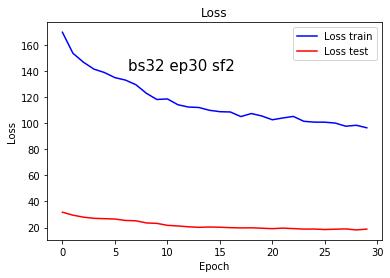

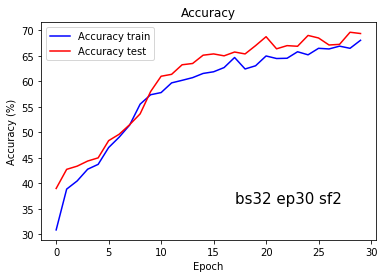

creating plot for sf:2 e:30 done !


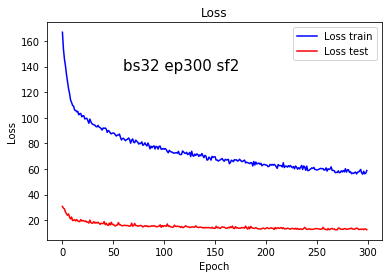

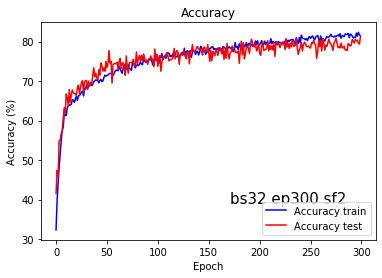

creating plot for sf:2 e:300 done !


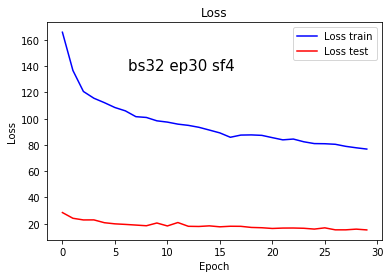

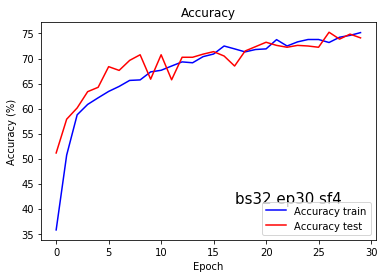

creating plot for sf:4 e:30 done !


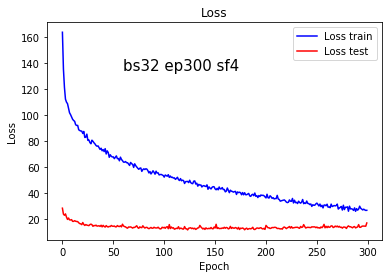

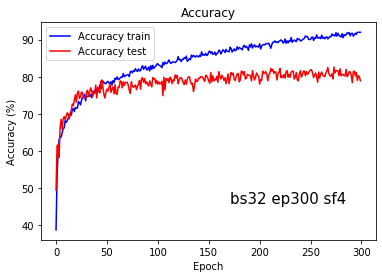

creating plot for sf:4 e:300 done !


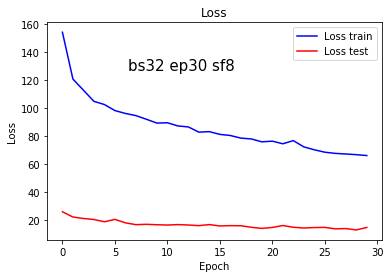

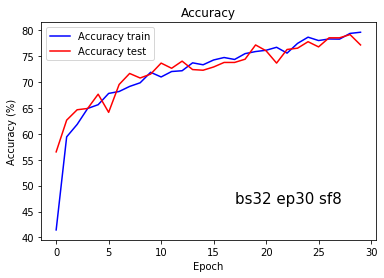

creating plot for sf:8 e:30 done !


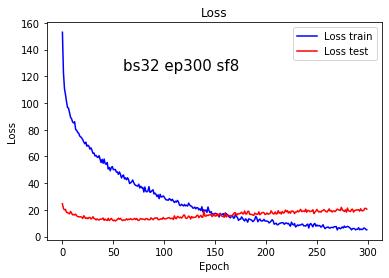

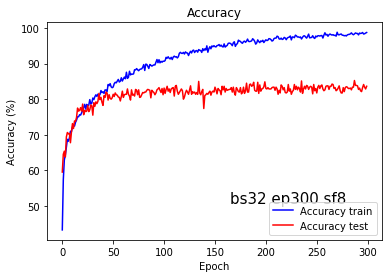

creating plot for sf:8 e:300 done !


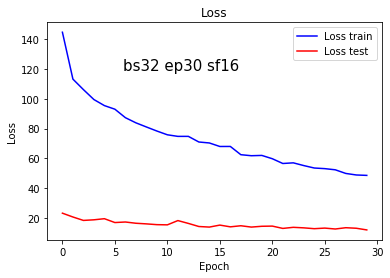

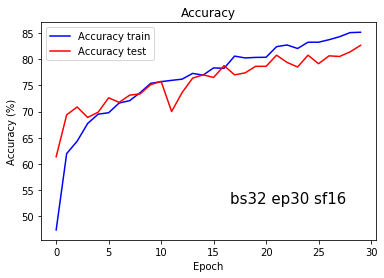

creating plot for sf:16 e:30 done !


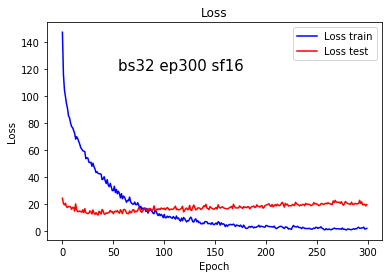

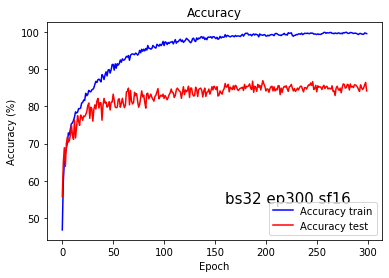

creating plot for sf:16 e:300 done !


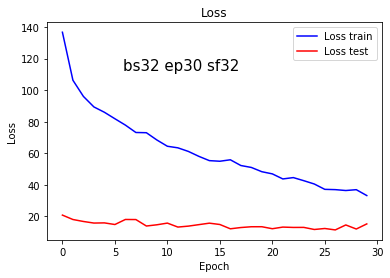

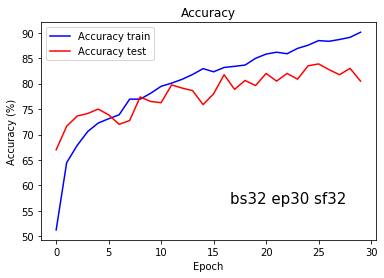

creating plot for sf:32 e:30 done !


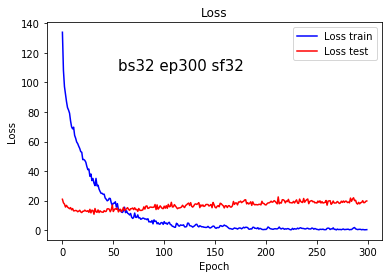

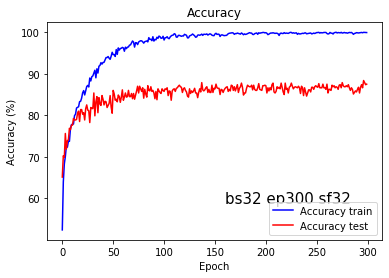

creating plot for sf:32 e:300 done !


In [7]:
#Test

epoch = [30 , 300]
sf = [2,4,8,16,32]
for s in sf:
    for e in epoch:
        main(batch_size=32, size_factor=s, epoch=e)
        print("sf:" + str(s) + " e:" + str(e) + " done !")
    
for s in sf:
    for e in epoch:
        plot(batch_size=32, size_factor=s, epoch=e)
        print("creating plot for sf:" + str(s) + " e:" + str(e) + " done !")



/home/brain/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brain/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brain/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brain/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". I

sf:64 e:30 done !


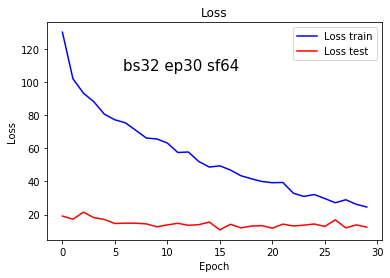

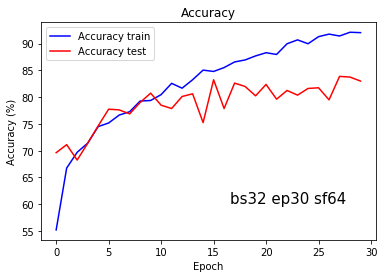

creating plot for sf:64 e:30 done !


In [ ]:
epoch = [30, 300]
for e in epoch:
    main(batch_size=32, size_factor=64, epoch=e)
    print("sf:" + str(64) + " e:" + str(e) + " done !")
    plot(batch_size=32, size_factor=64, epoch=e)
    print("creating plot for sf:" + str(64) + " e:" + str(e) + " done !")